In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

In [2]:
def get_ds_infos():
    ## 0:Code, 1:Weight, 2:Height, 3:Age, 4:Gender
    dss = np.genfromtxt("data_subjects_info.csv", delimiter=',')
    dss = dss[1:]
    print("...--> Data subjects information is imported.")
    return dss
##____________

def creat_time_series(num_features, num_act_labels, num_id_labels, label_codes, trial_codes):
    dataset_columns = num_features+num_act_labels+num_id_labels
    ds_list = get_ds_infos()
    train_data = np.zeros((0,dataset_columns))
    test_data = np.zeros((0,dataset_columns))
    feature = "userAcceleration"
    axes = [feature+".x", feature+".y", feature+".z"]
    for sub_id in ds_list[:,0]:
        
        for act in label_codes:
            for trial in trial_codes[act[0]]:
                fname = 'A_DeviceMotion_data/'+act[0]+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                raw_data = (raw_data[axes]**2).sum(axis=1)**0.5
                unlabel_data = raw_data[:,np.newaxis] 
                label_data = np.zeros((len(unlabel_data), dataset_columns))
                label_data[:,:-(num_act_labels + num_id_labels)] = unlabel_data
                label_data[:,act[1]] = 1
                label_data[:,int(sub_id) - (num_id_labels+1)] = 1
                # We consider long trials as training dataset and short trials as test dataset
                if trial > 10:
                    test_data = np.append(test_data, label_data, axis = 0)
                else:    
                    train_data = np.append(train_data, label_data, axis = 0)
                #train_data = np.append(train_data, label_data, axis = 0)
    return train_data , test_data
#________________________________


print("--> Start...")
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
num_features = 1 # attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
num_act_labels = 4 # dws, ups, wlk, jog
num_id_labels = 24 # sub_1, sub_2, ..., sub_24
sample_rate = 50
label_codes = [["dws",num_features], ["ups",num_features+1], ["wlk",num_features+2], ["jog",num_features+3]]
trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16]}    
## Calling 'creat_time_series()' to build time-series
print("--> Building Training and Test Datasets...")
train_ts, test_ts = creat_time_series(num_features, num_act_labels, num_id_labels, label_codes, trial_codes)
print("--> Shape of Training Time-Seires:"+str(train_ts.shape))
print("--> Shape of Test Time-Series:", test_ts.shape)

--> Start...
--> Building Training and Test Datasets...
...--> Data subjects information is imported.
--> Shape of Training Time-Seires:(621973, 29)
--> Shape of Test Time-Series: (145687, 29)


In [3]:
plt.rcParams['figure.figsize'] = (15,6)
plt.rcParams['font.size'] = 16
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

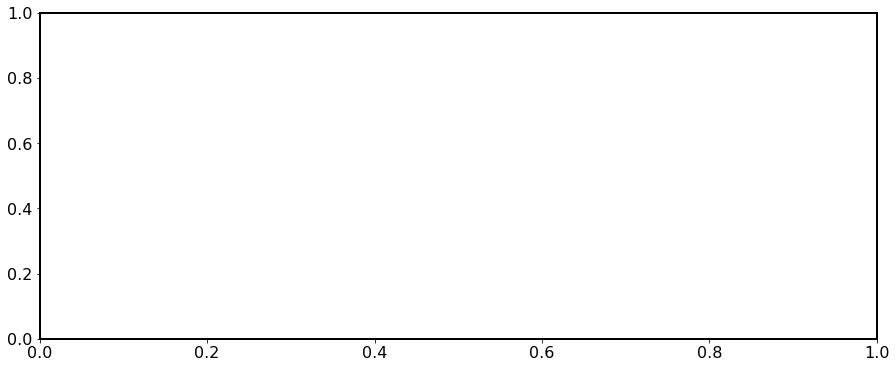

In [4]:
period = 45 # Seconds
points = period*sample_rate
acorr_lags = np.zeros((4,points))
for i in range(1,5):
    corr = np.zeros(points)
    for j in range(1,25):
        data = train_ts[np.logical_and(train_ts[:,i]==1,train_ts[:,-j]==1)]
        data = data[:points,0]
        data = pd.Series(data)
        aut_plt = autocorrelation_plot(data)
        corr += ((aut_plt.lines[5]).get_ydata())
        cnf_int_99 = aut_plt.lines[0].get_ydata()[0]
        cnf_int_95 = aut_plt.lines[1].get_ydata()[0]
        aut_plt.cla()    
    acorr_lags[i-1,:] = corr[:]/24.


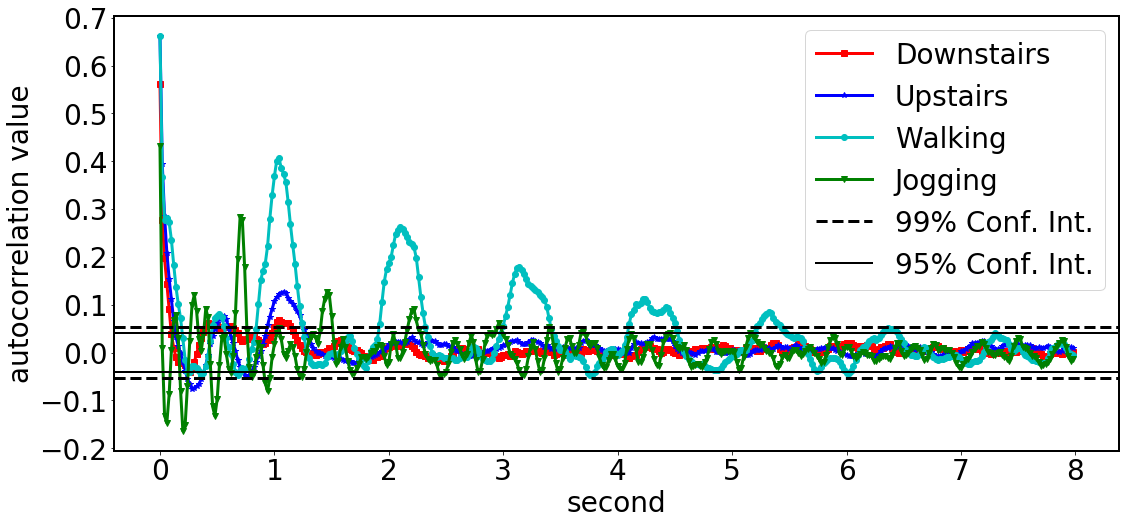

In [5]:
plt.rcParams['figure.figsize'] = (18,8)
plt.rcParams['font.size'] = 28
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
w = 400
s = 1
clr = ["rs-","b*-","co-","gv-"]   
lbl = ["Downstairs","Upstairs","Walking","Jogging"]
for i in range(4):
    plt.plot(np.arange(0.,400./50.,1./50), acorr_lags[i,0:w][::s],clr[i], linewidth=3, label=lbl[i])
plt.axhline(y=cnf_int_99, linestyle='--', color='k',linewidth=3, label='99% Conf. Int.')
plt.axhline(y=cnf_int_95, color='k',linewidth=2, label='95% Conf. Int.')
plt.axhline(y=-cnf_int_99, linestyle='--', color='k',linewidth=3)
plt.axhline(y=-cnf_int_95, color='k',linewidth=2,)
x_rng = np.arange(0.,401./50.,1.)
plt.xticks(x_rng)
plt.yticks(np.arange(-.2,.8,0.1))
plt.xlabel("second")
plt.ylabel("autocorrelation value")
plt.legend(loc="upper right")

0
12
18


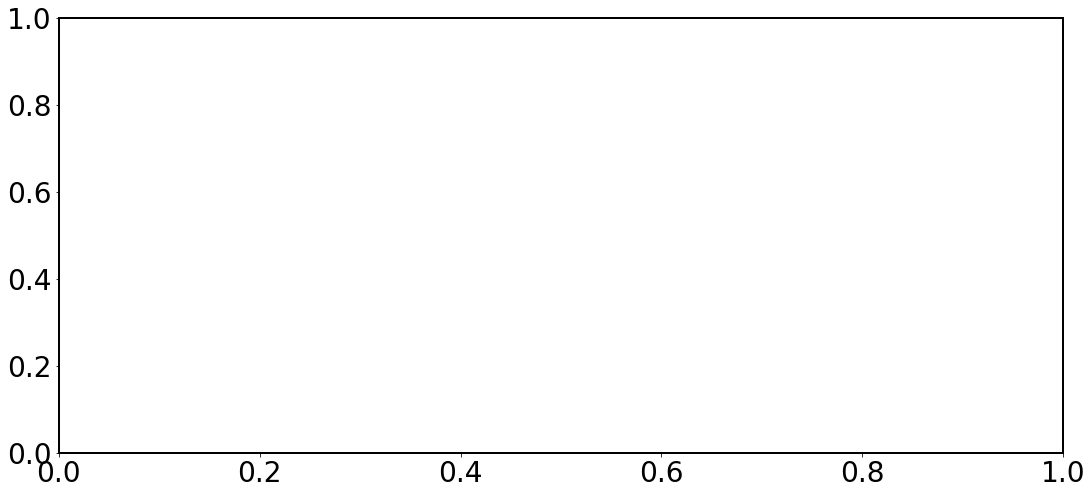

In [6]:
period = 45 # Seconds
points = period*sample_rate
acorr_lags = np.zeros((3,points))
k=0
for i in [0,12,18]:
    corr = np.zeros(points)
    for j in range(3,4):
        print(i)
        data = train_ts[np.logical_and(train_ts[:,j]==1,train_ts[:,-(24-i)]==1)]
        data = data[:points,0]
        data = pd.Series(data)
        aut_plt = autocorrelation_plot(data)
        corr += ((aut_plt.lines[5]).get_ydata())
        cnf_int_99 = aut_plt.lines[0].get_ydata()[0]
        cnf_int_95 = aut_plt.lines[1].get_ydata()[0]
        aut_plt.cla()     
    acorr_lags[k,:] = corr[:]/1.
    k+=1

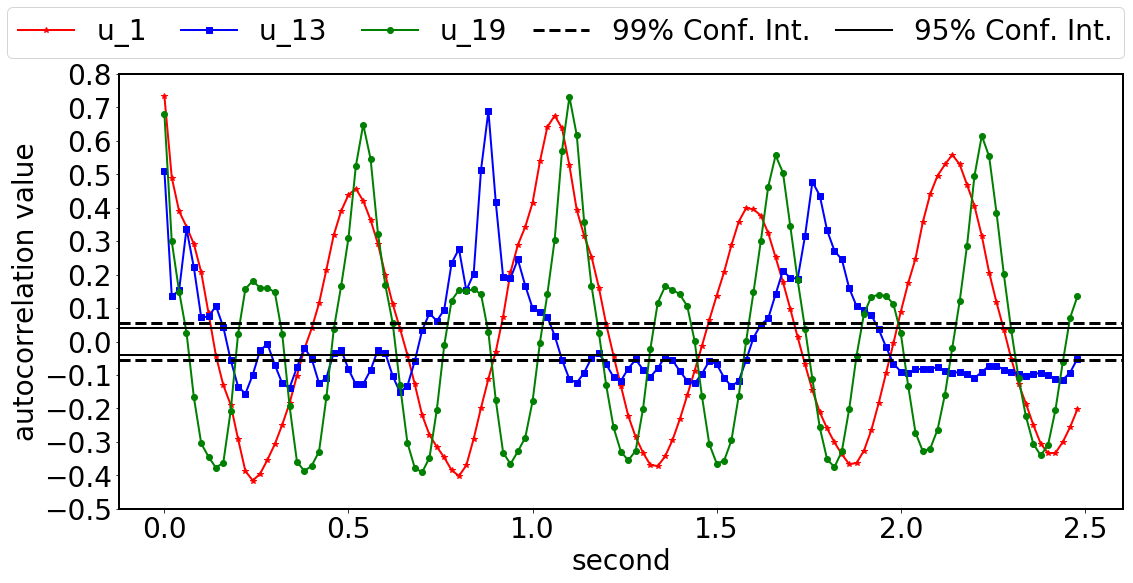

In [7]:
w = 125
s = 1
clr = ["r*-","bs-","go-"]   
#lbl = ["u_1 {102, 188, 46, M}","u_13 {60, 178, 33, M}","u_19 {78, 164, 28, F}"]
lbl = ["u_1 ","u_13 ","u_19"]

for i in range(3):
    plt.plot(np.arange(0.,w/50.,1./50), acorr_lags[i,0:w][::s],clr[i], linewidth=2, label=lbl[i])
plt.axhline(y=cnf_int_99, linestyle='--', color='k',linewidth=3, label='99% Conf. Int.')
plt.axhline(y=cnf_int_95, color='k',linewidth=2, label='95% Conf. Int.')
plt.axhline(y=-cnf_int_99, linestyle='--', color='k',linewidth=3)
plt.axhline(y=-cnf_int_95, color='k',linewidth=2,)
x_rng = np.arange(0.,126./50.,.5)
plt.xticks(x_rng)
plt.yticks(np.arange(-.5,0.81,0.1))
plt.xlabel("second", fontsize=28)
plt.ylabel("autocorrelation value", fontsize=28)
plt.legend(bbox_to_anchor=(-0.125, 1.02, 1.14, .15),loc="center",  mode="expand", ncol=5)